In [167]:
import pathlib

import astropy.coordinates as coord
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

import scipy.interpolate as sci

from pyia import GaiaData

# from dustmaps.sfd import SFDQuery

from dustmaps.planck import PlanckGNILCQuery

In [5]:
vcirc = 229 * u.km/u.s
galcen_frame = coord.Galactocentric()
galcen_frame

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>

In [172]:
# t1 = at.Table.read(pathlib.Path('~/data/Gaia/EDR3/edr3-rv-good-plx-result.fits').expanduser())
t1 = at.Table.read(pathlib.Path('~/data/Gaia/DR3/dr3-rv-good-plx-MilkyWayPotential2022-joined.fits').expanduser())
t2 = at.Table.read(pathlib.Path('~/data/Gaia/EDR3/edr3-rv-good-plx-2mass-xm.fits.gz').expanduser())
t = at.join(t1, t2, keys='source_id', metadata_conflicts='silent')
t = at.unique(t, keys='source_id')

In [184]:
g = GaiaData(t)
c = g.get_skycoord()

# TODO: use updated galactocentric frame
galcen = c.transform_to(coord.Galactocentric())

In [214]:
# iso = at.Table.read('/Users/apricewhelan/data/Isochrones/mist/mist_v1.2_vvcrit0.0.fits')
isos = {
    '-0.5': at.Table.read('/mnt/home/apricewhelan/data/isochrones/mist/FeH_-0.5_iso.fits'),
    '0.0': at.Table.read('/mnt/home/apricewhelan/data/isochrones/mist/FeH_0.0_iso.fits'),
    '0.5': at.Table.read('/mnt/home/apricewhelan/data/isochrones/mist/FeH_0.5_iso.fits')
}
for feh, iso in isos.items():
    isos[feh] = iso[(iso['phase'] < 1)]

/mnt/home/apricewhelan/anaconda3/lib/python3.9/site-packages/astropy/io/fits/column.py:831: VerifyWarning: It is strongly recommended that column names contain only upper and lower-case ASCII letters, digits, or underscores for maximum compatibility with other software (got '[Fe/H]_init').
  warnings.warn(

/mnt/home/apricewhelan/anaconda3/lib/python3.9/site-packages/astropy/io/fits/column.py:831: VerifyWarning: It is strongly recommended that column names contain only upper and lower-case ASCII letters, digits, or underscores for maximum compatibility with other software (got '[Fe/H]').
  warnings.warn(



In [180]:
dustmap = PlanckGNILCQuery()

In [185]:
ebv = dustmap.query(c)

In [186]:
AJ = 0.72 * ebv
AH = 0.46 * ebv
AK = 0.306 * ebv

In [196]:
data_H = g.h_m - g.distmod - AH*u.mag
data_JK = g.j_m - g.ks_m - (AJ - AK)*u.mag
b_mask = np.abs(c.galactic.b) > 5*u.deg

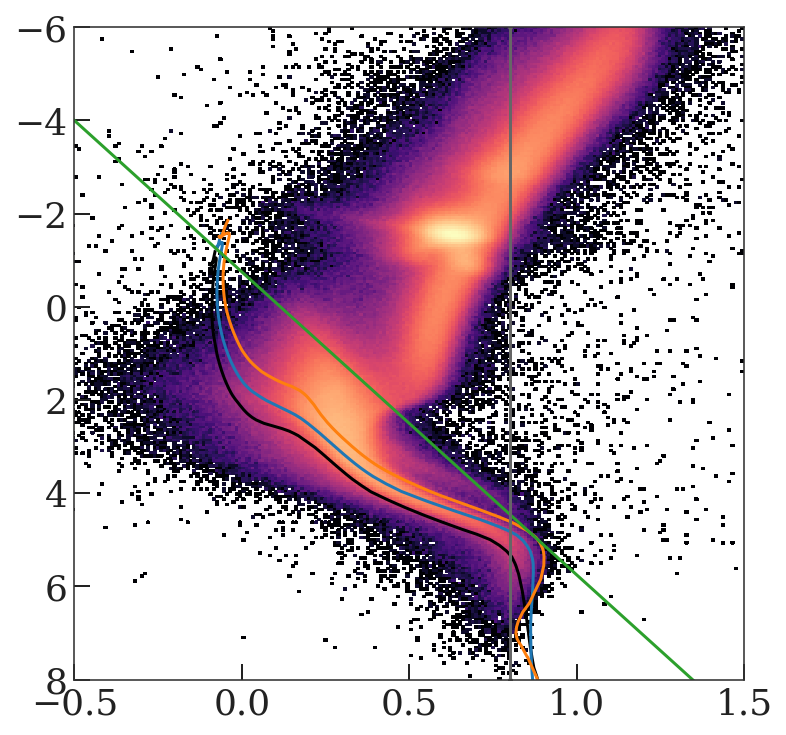

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist2d(
    data_JK.value[b_mask], 
    data_H.value[b_mask],  
    bins=(np.linspace(-1, 1.5, 256),
          np.linspace(-6, 8, 256)),
    norm=mpl.colors.LogNorm()
)

iso_82s = {k: v[np.isclose(v['log10_isochrone_age_yr'], 8.2)]
           for k, v in isos.items()}
for iso in iso_82s.values():
    ax.plot(
        iso['J'] - iso['Ks'], 
        iso['H'], 
        marker=''
    )
    
ms_cut = lambda jk: 6.5 * jk - 0.75
_x = np.linspace(-0.5, 1.5, 128)
ax.plot(_x, ms_cut(_x), marker='')
ms_mask = data_H.value > ms_cut(data_JK.value)

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(8, -6)

ax.axvline(0.8)

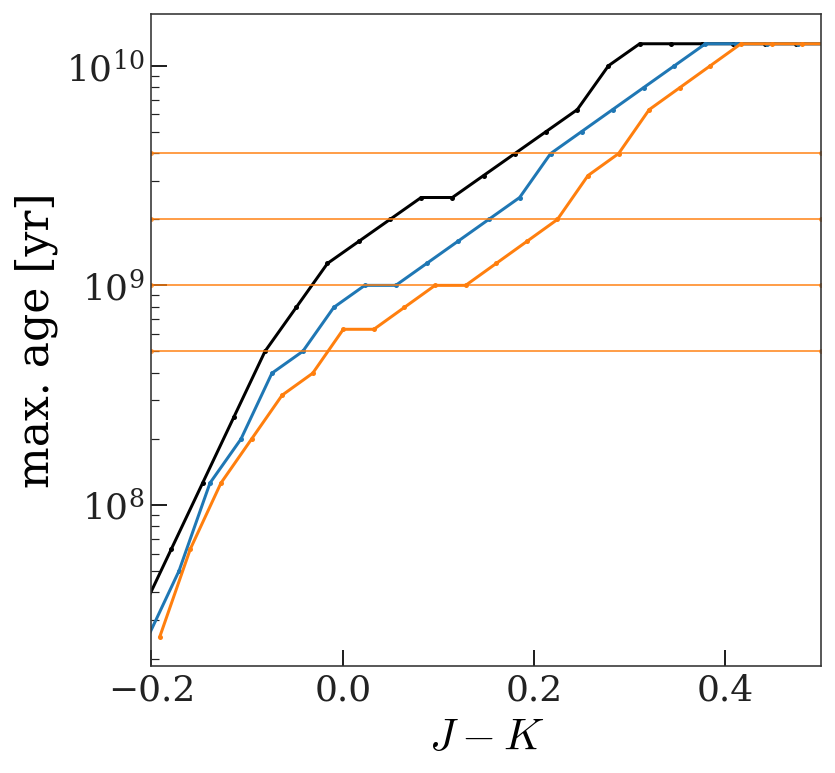

In [216]:
all_jk_vals = {}
all_max_ages = {}
for k, iso in isos.items():
    jk = iso['J'] - iso['Ks']
    _mask = jk < 0.8

    jk_vals = np.linspace(jk.min(), 0.8, 32)
    all_jk_vals[k] = jk_vals
    
    max_ages = np.zeros_like(jk_vals)
    for i, val in enumerate(jk_vals):
        jk_mask = (np.abs(jk - val) < 0.05) & _mask
        max_ages[i] = 10 ** iso['log10_isochrone_age_yr'][jk_mask].max()
    max_ages = max_ages * u.yr
    all_max_ages[k] = max_ages

    plt.plot(jk_vals, max_ages.value)

plt.yscale('log')
plt.xlim(-0.2, 0.5)

plt.xlabel('$J-K$')
plt.ylabel('max. age [yr]')

age_bins = np.array([0, 0.5, 1, 2, 4, 10]) * u.Gyr
for age_line in age_bins[1:-1].to_value(u.yr):
    plt.axhline(age_line, ls='-', alpha=0.75, color='tab:orange', lw=1)

In [217]:
del_idx = np.where(np.diff(all_max_ages['0.0']) == 0)[0] + 1
tmp_x = np.delete(all_max_ages['0.0'], del_idx)
tmp_y = np.delete(all_jk_vals['0.0'], del_idx)

interp = sci.InterpolatedUnivariateSpline(
    tmp_x.to_value(u.Gyr),
    tmp_y,
    k=3
)
jk_bins = interp(age_bins.to_value(u.Gyr)) * u.mag

In [218]:
# clean_mask = (tbl['ruwe'] < 1.4)
dxy_mask = np.linalg.norm(g.xyz[:, :2] - [-8.275, 0]*u.kpc, axis=1) < 2 * u.kpc
JR_mask = g.actions[:, 0] < (15 * u.km/u.s * 500*u.pc)

In [219]:
JR_mask.sum(), len(JR_mask)

(1102449, 5965897)

3069
3547
30185
52320
169579


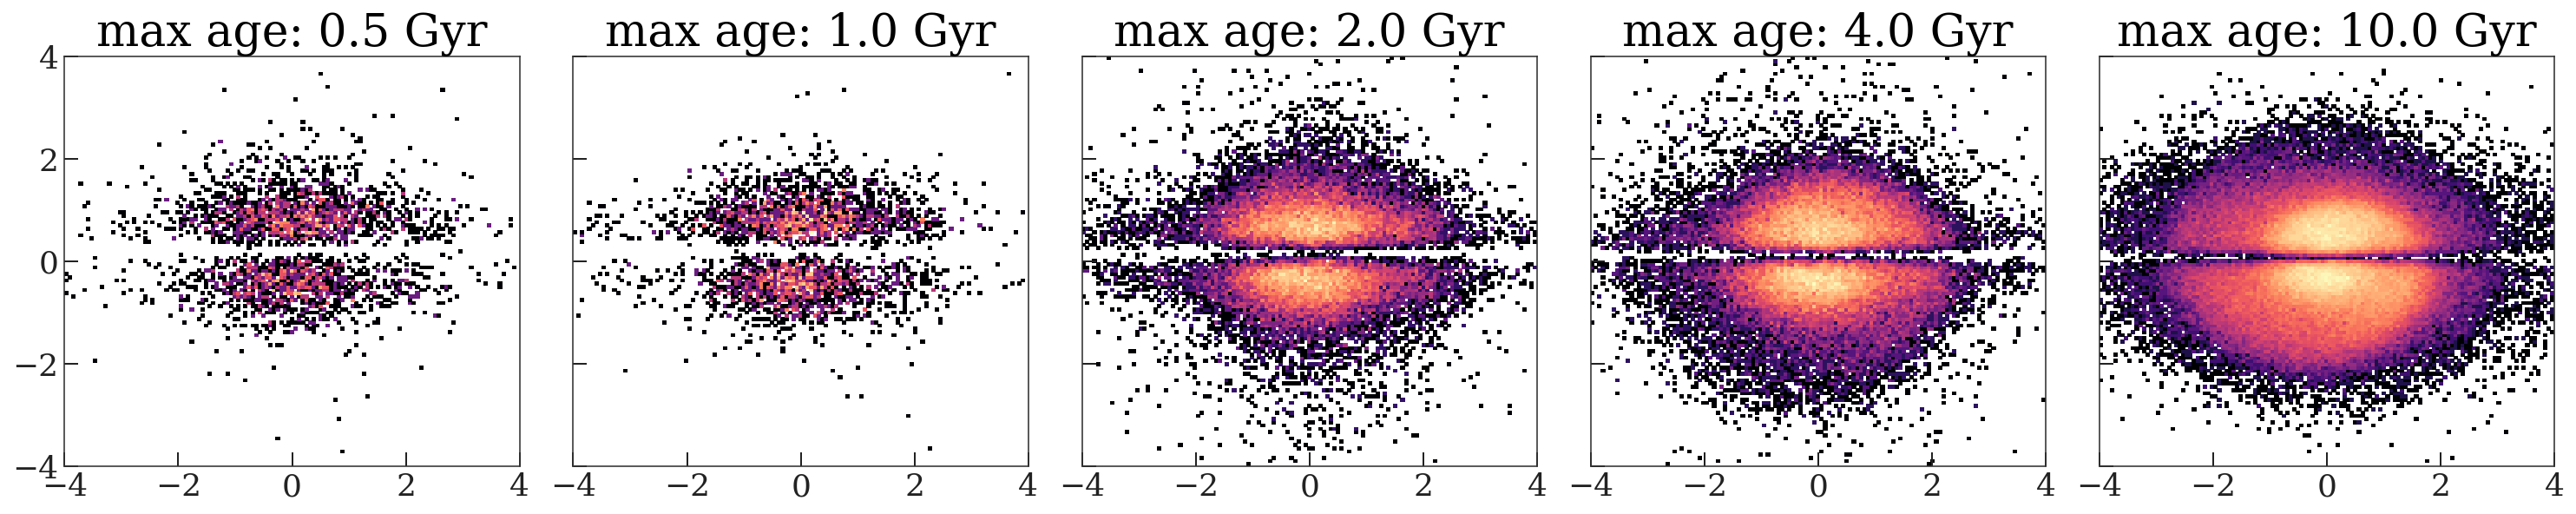

In [220]:
npanels = len(jk_bins) - 1
fig, axes = plt.subplots(
    1, npanels,
    figsize=(4.1 * npanels, 4),
    sharex=True,
    sharey=True,
    constrained_layout=True
)
for *jk_lim, ax, max_age in zip(jk_bins[:-1], jk_bins[1:], axes, age_bins.to_value(u.Gyr)[1:]):
    jk_mask = (data_JK > jk_lim[0]) & (data_JK < jk_lim[1])
    mask = jk_mask & ms_mask & dxy_mask & JR_mask & b_mask
    print(mask.sum())
    
    z = galcen.z[mask].to_value(u.kpc)
    vz = galcen.v_z[mask].to_value(u.km/u.s)    
    stdz = 1.5 * MAD(z)
    stdvz = 1.5 * MAD(vz)
    
    ax.hist2d(
        vz / stdvz,
        z / stdz,
        bins=(
            np.linspace(-4, 4, 128),
            np.linspace(-4, 4, 128)
        ),
        norm=mpl.colors.LogNorm()
    )
    
    ax.set_title(f'max age: {max_age:.1f} Gyr')